In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
# from spacy_language_detection import LanguageDetector
import scipy.stats as stats

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [14]:
us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")

C:\Users\Admin\AppData\Local\Temp\ipykernel_8088\3223522512.py:1: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")


In [15]:
# #keep only the beers which have an abv between 0 and 95% (to remove outliers)

# quantile_5 = us_users_ratings["abv"].quantile(0.05)
# quantile_95 = us_users_ratings["abv"].quantile(0.95)

# print("Shape before filtering:", us_users_ratings.shape)
# #us_abv_ratings = us_users_ratings[(us_users_ratings["abv"] > quantile_5) & (us_users_ratings["abv"] < quantile_95)]
# us_users_ratings = us_users_ratings[(us_users_ratings["abv"] > quantile_5) & (us_users_ratings["abv"] < quantile_95)]
# print("Shape after filtering:", us_users_ratings.shape)

## 1. How does the climate of a user impact their preference in beer style?

1. What type of beer do users from each climate prefer? Is there significance?
2. What is the most rated beer from each climate? Is it one they dislike or like strongly?
3. Is the alcohol percentage of the preferred beer significant to the respective climates?

First, we will need to preprocess the `us_users_ratings` dataset to add a `general_style` column that is made from the beer's `style` which can be very specific. Then, we need to group the beers by climate to do the analysis to find answers to our questions.  

In [16]:
us_users_ratings.head()

,beer_id,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,...,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,climate_scheme,climate_precipitation,climate_temperature
0,19827,1417431600,Hellpop65,hellpop65.48993,NaN,NaN,NaN,NaN,NaN,3.25,...,Strangford Lough Brewing Company Ltd,5,5,Kansas,2326.0,137,Cfa,Temperate,without dry season,hot summer
1,19827,1401357600,Latarnik,latarnik.52897,NaN,NaN,NaN,NaN,NaN,3.50,...,Strangford Lough Brewing Company Ltd,5,5,New Jersey,3098.0,137,Cfa,Temperate,without dry season,hot summer
2,19827,1393412400,RochefortChris,rochefortchris.697017,NaN,NaN,NaN,NaN,NaN,3.50,...,Strangford Lough Brewing Company Ltd,5,5,North Carolina,1866.0,137,Cfa,Temperate,without dry season,hot summer
3,19827,1392030000,OKCNittany,okcnittany.144868,NaN,NaN,NaN,NaN,NaN,3.75,...,Strangford Lough Brewing Company Ltd,5,5,Oklahoma,1131.0,137,Cfa,Temperate,without dry season,hot summer
4,19827,1390647600,jaydoc,jaydoc.265507,NaN,NaN,NaN,NaN,NaN,3.25,...,Strangford Lough Brewing Company Ltd,5,5,Kansas,9987.0,137,Cfa,Temperate,without dry season,hot summer


As there are many different styles of beer, it seems too hard to automate the process of tokenisation. We chose to export the dataframe with the style of beer and manually assign each one to a more general style. The groupings were made based on this reference: https://hospitalityinsights.ehl.edu/beer-types. These are:
- Lager
- Pale Ale
- Blonde Ale
- Brown Ale
- IPA
- Wheatbeer
- Porter
- Stout
- Sour Ale
- Scottish Ale

In [17]:
# get all styles of beers to regroup them by general types

beer_styles = us_users_ratings[["style"]].copy()
beer_styles = beer_styles.drop_duplicates()
# beer_styles.to_excel(r'beer_style.xlsx', index=False)

print("There are {} different beer styles in the dataset".format(len(beer_styles)))
beer_styles.head()

There are 104 different beer styles in the dataset


,style
0,English Pale Ale
70,English Bitter
127,English India Pale Ale (IPA)
166,American Double / Imperial IPA
167,American Amber / Red Ale


In [18]:
# reimport edited file with the corresponding beer types
mapping_df = pd.DataFrame(pd.read_excel("beer_style_edited.xlsx"))
print(
    "There are {} different general beer types".format(
        len(set(mapping_df["general_style"]))
    )
)

# extract all general beer types
general_beer_types = list(set(mapping_df["general_style"]))
print(general_beer_types)

# add a column to the us_users_ratings dataframe with the corresponding general beer type
us_users_ratings = pd.merge(us_users_ratings, mapping_df, on="style", how="left")
us_users_ratings.head()

There are 10 different general beer types
['Lager', 'Pale Ale', 'Sour Ale', 'Wheat beer', 'Brown Ale', 'Blonde Ale', 'Stout', 'Porter', 'IPA', 'Scottish Ale ']


,beer_id,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,...,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,climate_scheme,climate_precipitation,climate_temperature,general_style
0,19827,1417431600,Hellpop65,hellpop65.48993,NaN,NaN,NaN,NaN,NaN,3.25,...,5,5,Kansas,2326.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
1,19827,1401357600,Latarnik,latarnik.52897,NaN,NaN,NaN,NaN,NaN,3.50,...,5,5,New Jersey,3098.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
2,19827,1393412400,RochefortChris,rochefortchris.697017,NaN,NaN,NaN,NaN,NaN,3.50,...,5,5,North Carolina,1866.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
3,19827,1392030000,OKCNittany,okcnittany.144868,NaN,NaN,NaN,NaN,NaN,3.75,...,5,5,Oklahoma,1131.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
4,19827,1390647600,jaydoc,jaydoc.265507,NaN,NaN,NaN,NaN,NaN,3.25,...,5,5,Kansas,9987.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale


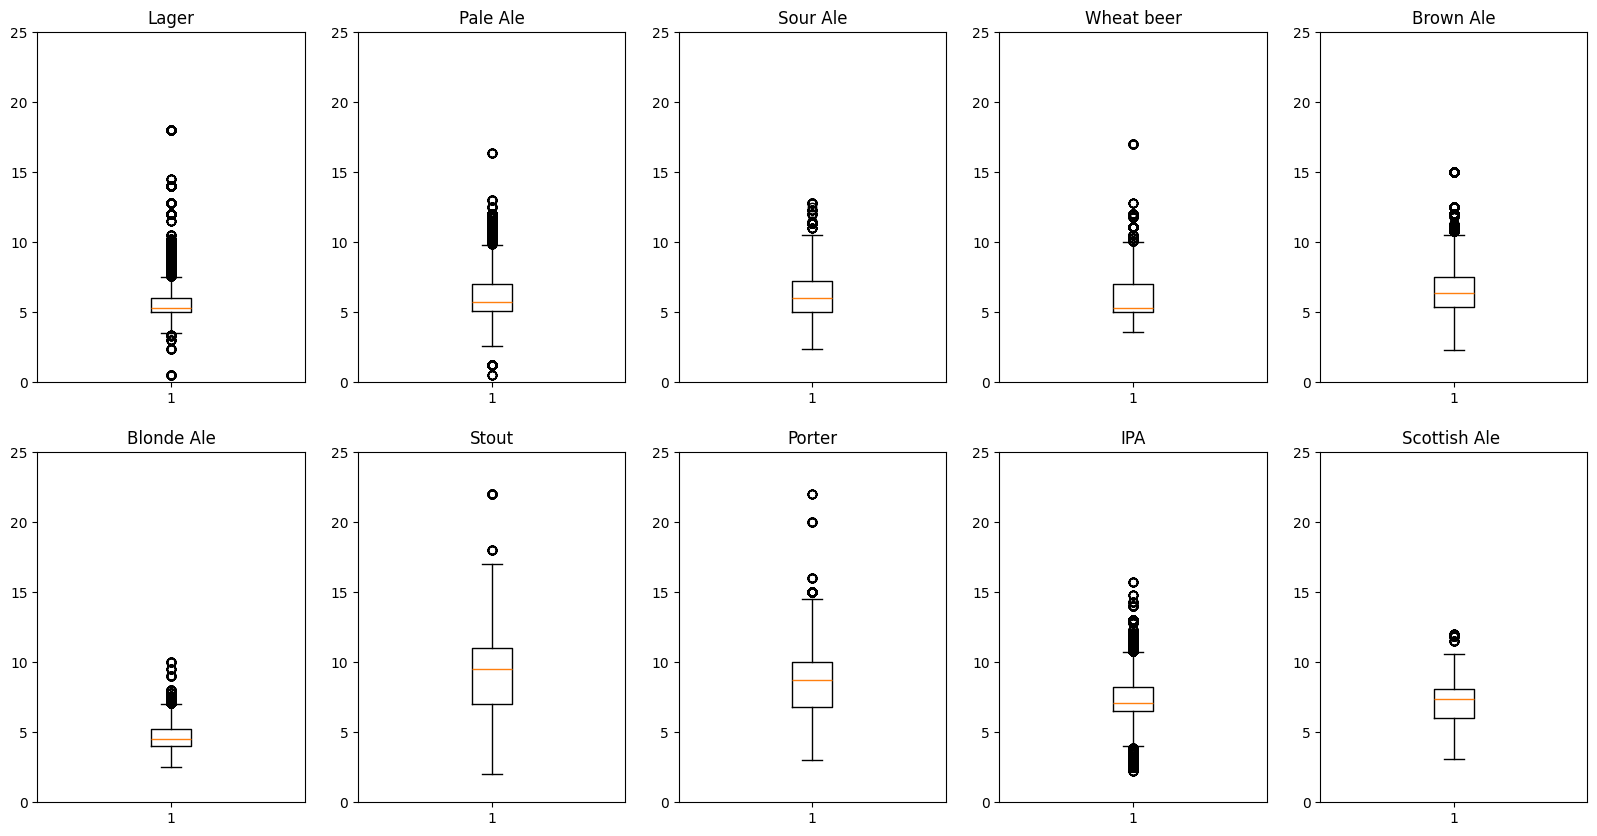

In [19]:
# boxplot of abv for each general beer type

fig, axs = plt.subplots(2, 5, figsize=(20, 10))

for i, beer_type in enumerate(general_beer_types):
    # general_beer_type = general_beer_types[i]
    ax = axs[i // 5, i % 5]
    general_beer_type_df = us_users_ratings[
        us_users_ratings["general_style"] == beer_type
    ]
    ax.boxplot(general_beer_type_df["abv"])
    ax.set_title(beer_type)
    # set y axis limits
    ax.set_ylim(0, 25)

plt.savefig("abv_boxplot_styles.png", dpi=600)
plt.show()

In [20]:
# group by the climates and aggregate the overall rating per type of beer

climate_beer_type = (
    us_users_ratings.groupby(["climate", "general_style"])["overall"]
    .mean()
    .reset_index()
)
print(climate_beer_type["climate"].unique())
print(
    "There are {} different climates".format(len(climate_beer_type["climate"].unique()))
)
climate_beer_type.head()

['Bsk' 'Cfa' 'Cfb' 'Csa' 'Csb' 'Dfa' 'Dfb' 'Dfc' 'Dsb' 'Dsc']
There are 10 different climates


,climate,general_style,overall
0,Bsk,Blonde Ale,3.609113
1,Bsk,Brown Ale,3.829035
2,Bsk,IPA,3.925113
3,Bsk,Lager,3.492398
4,Bsk,Pale Ale,3.673315


<Axes: xlabel='climate', ylabel='general_style'>

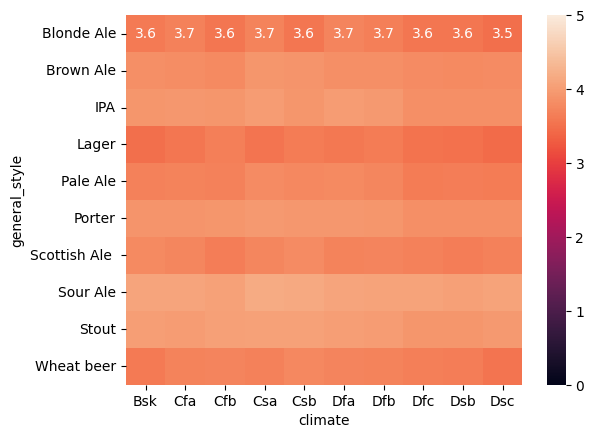

In [21]:
# heatmap of the ratings given to each beer type in each climate

df = pd.crosstab(
    climate_beer_type["general_style"],
    climate_beer_type["climate"],
    values=climate_beer_type["overall"],
    aggfunc="mean",
)
sns.heatmap(df, annot=True, vmin=0, vmax=5)

There doesn't seem to be a significant difference between the ratings between the climates. There do seem to be types of beers that are generally preffered than others. Let's try to analyse these results in a bit more detail to look for significant differences. For example, the Dsc climate seems to have the most variety in results so we can explore this one first.

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

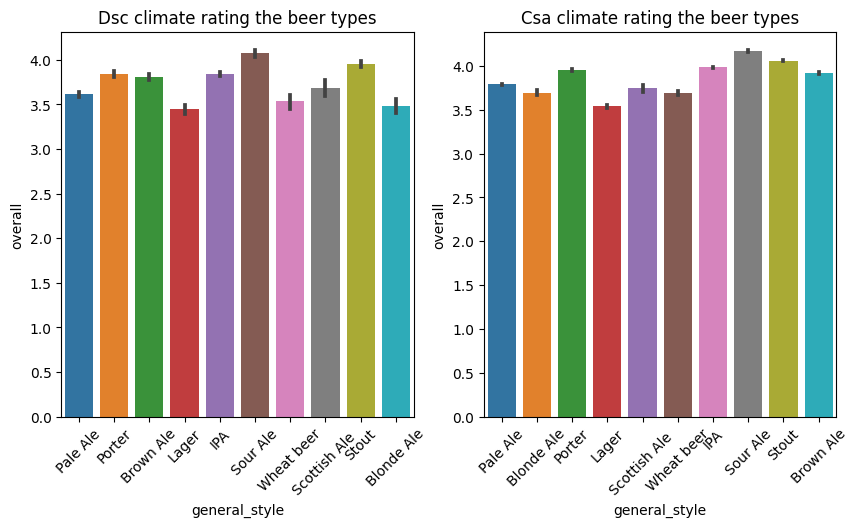

In [22]:
# view the average rating per beer type in Dsc and Csa

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

plot_1 = sns.barplot(
    x="general_style",
    y="overall",
    data=us_users_ratings[us_users_ratings["climate"] == "Dsc"],
    ax=ax0,
)
plot_1.set_xticklabels(plot_1.get_xticklabels(), rotation=45)
plot_1.set_title("Dsc climate rating the beer types")

plot_2 = sns.barplot(
    x="general_style",
    y="overall",
    data=us_users_ratings[us_users_ratings["climate"] == "Csa"],
    ax=ax1,
)
plot_2.set_xticklabels(plot_2.get_xticklabels(), rotation=45)
plot_2.set_title("Csa climate rating the beer types")

plt.show()

In [23]:
# For each climate, performe a chi2 test on the overall rating and the general style
# H0: the two variables are independent

for climate in us_users_ratings["climate"].unique():
    data_to_test = us_users_ratings[us_users_ratings["climate"] == climate][
        ["overall", "general_style"]
    ]
    contingency_table = pd.crosstab(
        data_to_test["overall"], data_to_test["general_style"]
    )
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print("P-value for the {} climate is {:.5f}".format(climate, p))

P-value for the Cfa climate is 0.00000
P-value for the Dfb climate is 0.00000
P-value for the Csa climate is 0.00000
P-value for the Dfa climate is 0.00000
P-value for the Cfb climate is 0.00000
P-value for the Dfc climate is 0.00000
P-value for the Csb climate is 0.00000
P-value for the Dsc climate is 0.00000
P-value for the Dsb climate is 0.00000
P-value for the Bsk climate is 0.00000


All p-values of the chi2 tests are smaller than the critical value (0.05) so we fail to reject the null hypothesis ie. for each climate, the overall rating of each beer is significantly independant. 

In [24]:
# Microaverage: compute the mean overall rating for all users
micro_av_overall = us_users_ratings["overall"].mean()
print("The micro average overall rating is {:.4f}".format(micro_av_overall))

# Macroaverage: compute statistics for each climate, then take the mean
climate_av_overall = (
    us_users_ratings.groupby("climate")["overall"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
climate_av_overall.set_index("climate", inplace=True)
macro_av_overall = climate_av_overall["overall"].mean()
print("The macro average overall rating is {:.4f}".format(macro_av_overall))

The micro average overall rating is 3.8582
The macro average overall rating is 3.8342


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

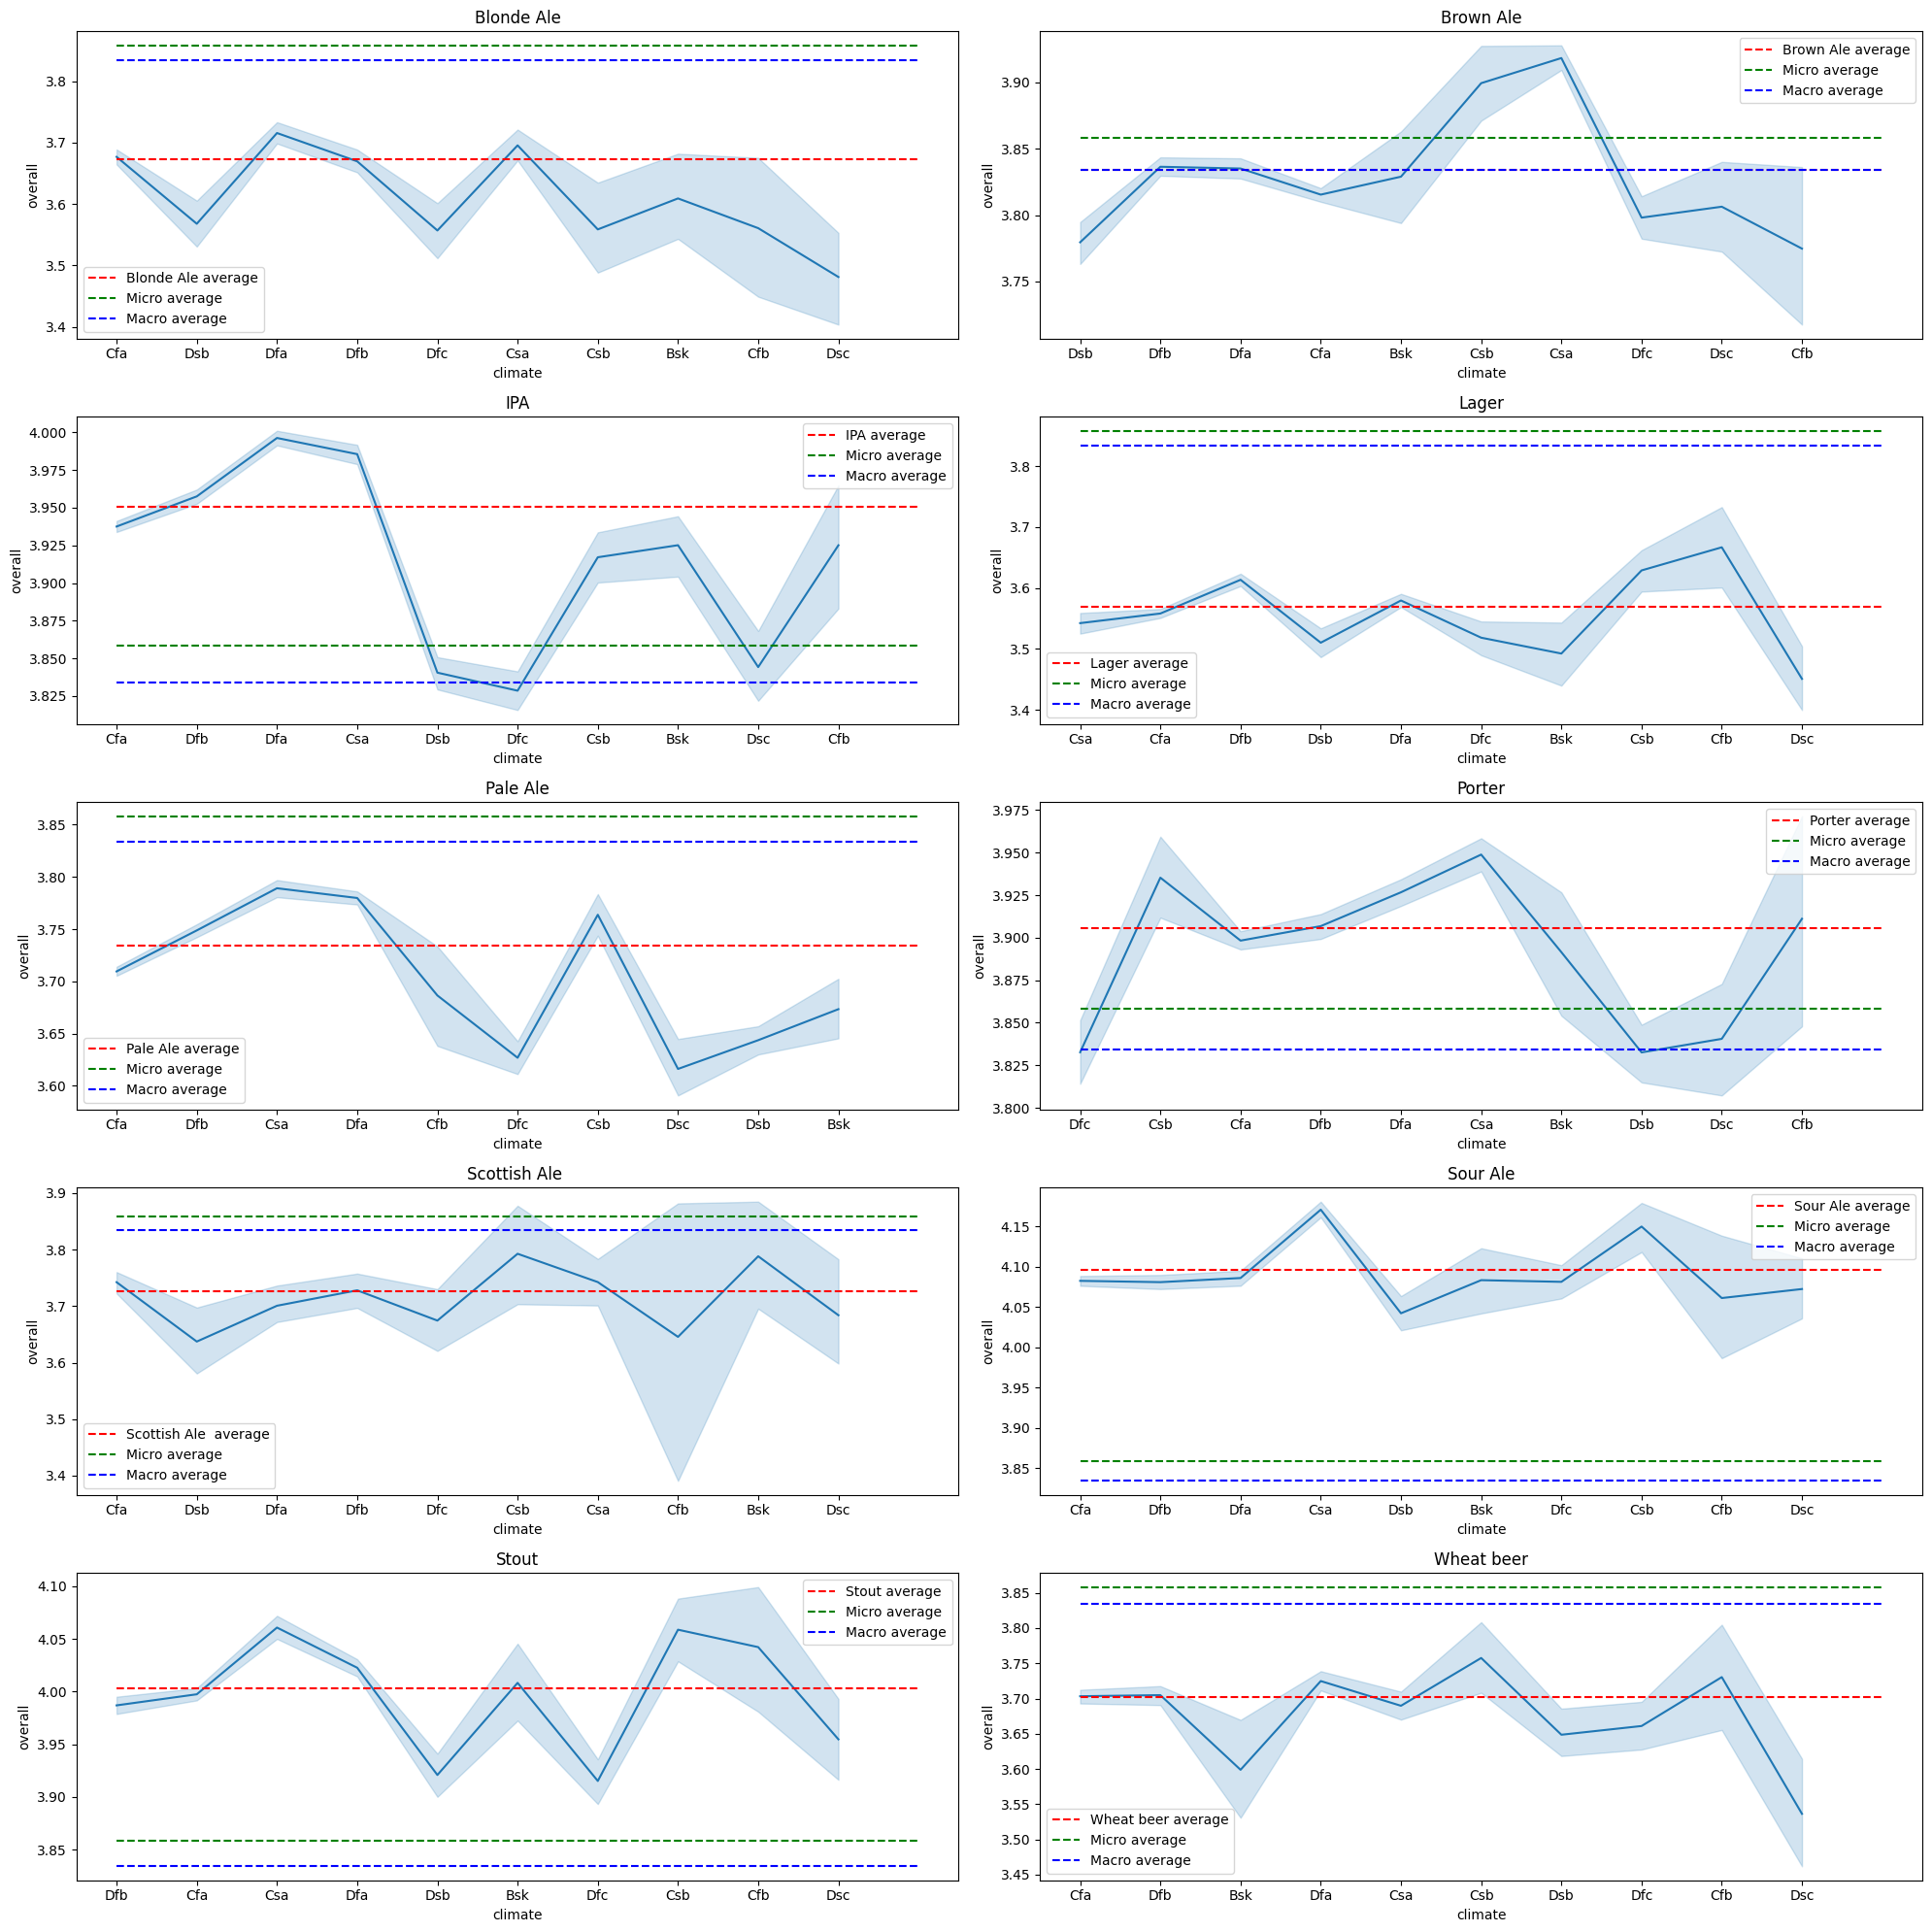

In [25]:
# Plot the different beer type means as a function of the climate for all beers

num_scores = len(climate_beer_type["climate"].unique())
fig, axs = plt.subplots(num_scores // 2, 2, figsize=(20, 20))

for i, beer_type in enumerate(climate_beer_type["general_style"].unique()):
    # compute average beer rating for that beer type
    beer_type_av_overall = us_users_ratings[
        us_users_ratings["general_style"] == beer_type
    ]["overall"].mean()

    # plot the overall beer ratings for each type, climate and the different averagers
    ax = axs[i // 2, i % 2]
    sns.lineplot(
        x="climate",
        y="overall",
        data=us_users_ratings[us_users_ratings["general_style"] == beer_type],
        ax=ax,
    )
    ax.set_title(beer_type)
    ax.plot(
        [0, num_scores],
        [beer_type_av_overall, beer_type_av_overall],
        "r--",
        label="{} average".format(beer_type),
    )
    ax.plot(
        [0, num_scores],
        [micro_av_overall, micro_av_overall],
        "g--",
        label="Micro average",
    )
    ax.plot(
        [0, num_scores],
        [macro_av_overall, macro_av_overall],
        "b--",
        label="Macro average",
    )
    ax.legend()

plt.tight_layout()
plt.show()

The four different averages are:
- beer macro average: moyenne des averages par climat pour ce type de biere
- beer micro average: moyenne de tous les averages pour ce type de biere
- macro average: moyenne des averages par climat de toutes les bieres
- micro average: moyenne de tous les averages

It can be noted that the beer macro and micro averages are very similar for Wheat beer, Stout and Lager. This means that the average rating per climate is the same as the average rating overall ie. could be the same distribution or they compensate each other.

Furthermore, From these visualisations, the beers look to be in three main categories:
- beers that are rated better than the micro/macro averages (Stout, Sour Ale)
- beers that are rated better than the micro/macro averages (Wheat Beer,Lager, Blonde Ale, Scottish Ale, Pale Ale)
- beers with ratings that fluctuate around the micro/macro averages (Porter, IPA, Brown Ale)

In [26]:
# Can be useful
us_abv_ratings = us_users_ratings.copy()
abv_averge_per_beer_type = (
    us_abv_ratings.groupby(["general_style"])["abv"].mean().reset_index()
)
abv_averge_per_beer_type.head(10)

,general_style,abv
0,Blonde Ale,4.649168
1,Brown Ale,6.509311
2,IPA,7.396445
3,Lager,5.753463
4,Pale Ale,6.148200
5,Porter,8.575229
6,Scottish Ale,7.284264
7,Sour Ale,6.335150
8,Stout,9.177680
9,Wheat beer,5.908860


In [27]:
# Create a datafram which gives for each climate the general style ordered by the average overall rating
columns = ["climate"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate = pd.DataFrame(columns=columns)

for climate in climate_beer_type["climate"].unique():
    best_beers_per_climate.loc[climate] = [climate] + list(
        climate_beer_type[climate_beer_type["climate"] == climate]
        .sort_values(by="overall", ascending=False)["general_style"]
        .values[:10]
    )

best_beers_per_climate.head(10)

,climate,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
Bsk,Bsk,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Blonde Ale,Wheat beer,Lager
Cfa,Cfa,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager
Cfb,Cfb,Sour Ale,Stout,IPA,Porter,Brown Ale,Wheat beer,Pale Ale,Lager,Scottish Ale,Blonde Ale
Csa,Csa,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Blonde Ale,Wheat beer,Lager
Csb,Csb,Sour Ale,Stout,Porter,IPA,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Lager,Blonde Ale
Dfa,Dfa,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Wheat beer,Blonde Ale,Scottish Ale,Lager
Dfb,Dfb,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
Dfc,Dfc,Sour Ale,Stout,Porter,IPA,Brown Ale,Scottish Ale,Wheat beer,Pale Ale,Blonde Ale,Lager
Dsb,Dsb,Sour Ale,Stout,IPA,Porter,Brown Ale,Wheat beer,Pale Ale,Scottish Ale,Blonde Ale,Lager
Dsc,Dsc,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager


In [28]:
# Can compute average position for each beer type in the top 10 for each climate
beers_average_position = {}

for row in best_beers_per_climate.iterrows():
    for i, beer in enumerate(row[1][1:]):
        if beer in beers_average_position:
            beers_average_position[beer] += i + 1
        else:
            beers_average_position[beer] = i + 1

for beer in beers_average_position:
    beers_average_position[beer] /= len(best_beers_per_climate)

print("The average position of each beer type in the top 10 for each climate is:")
print(beers_average_position)

The average position of each beer type in the top 10 for each climate is:
{'Sour Ale': 1.0, 'Stout': 2.0, 'IPA': 3.2, 'Porter': 3.8, 'Brown Ale': 5.0, 'Scottish Ale ': 7.0, 'Pale Ale': 6.8, 'Blonde Ale': 8.9, 'Wheat beer': 7.6, 'Lager': 9.7}


In [29]:
# Now let's analyse the scheme of the climate and the overall rating
columns = ["climate_scheme"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_scheme = pd.DataFrame(columns=columns)
amount_reviews_per_climate_scheme = pd.DataFrame(columns=columns)

for climate_scheme in us_abv_ratings["climate_scheme"].unique():
    row = [climate_scheme] + list(
        us_abv_ratings[us_abv_ratings["climate_scheme"] == climate_scheme]
        .groupby(["general_style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["general_style"]
        .values[:10]
    )
    best_beers_per_climate_scheme.loc[len(best_beers_per_climate_scheme)] = row
    amount_reviews_per_climate_scheme.loc[len(amount_reviews_per_climate_scheme)] = [
        climate_scheme
    ] + list(
        us_abv_ratings[us_abv_ratings["climate_scheme"] == climate_scheme]
        .groupby(["general_style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:10]
    )

display(best_beers_per_climate_scheme)
display(amount_reviews_per_climate_scheme)

,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,Temperate,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager
1,Continental,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Wheat beer,Scottish Ale,Blonde Ale,Lager
2,Dry,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Blonde Ale,Wheat beer,Lager


,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,Temperate,118267,79628,54961,50771,39179,35466,32429,17208,11077,3920
1,Continental,115496,74989,48768,46117,35882,33047,27276,15328,10154,3225
2,Dry,2777,1826,1050,1008,818,720,656,324,270,102


In [30]:
# For each climate scheme, performe a chi2 test on the overall rating and the general style

for climate_scheme in us_abv_ratings["climate_scheme"].unique():
    data_to_test = us_abv_ratings[us_abv_ratings["climate_scheme"] == climate_scheme][
        ["overall", "general_style"]
    ]
    contingency_table = pd.crosstab(
        data_to_test["overall"], data_to_test["general_style"]
    )
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print("P-value for the {} climate scheme is {:.4f}".format(climate_scheme, p))

P-value for the Temperate climate scheme is 0.0000
P-value for the Continental climate scheme is 0.0000
P-value for the Dry climate scheme is 0.0000


In [31]:
# Now let's analyse the precipitation of the climate and the overall rating
columns = ["climate_precipitation"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_precipitation = pd.DataFrame(columns=columns)
amount_reviews_per_climate_precipitation = pd.DataFrame(columns=columns)

for climate_precipitation in us_abv_ratings["climate_precipitation"].unique():
    row = [climate_precipitation] + list(
        us_abv_ratings[us_abv_ratings["climate_precipitation"] == climate_precipitation]
        .groupby(["general_style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["general_style"]
        .values[:10]
    )
    best_beers_per_climate_precipitation.loc[
        len(best_beers_per_climate_precipitation)
    ] = row
    amount_reviews_per_climate_precipitation.loc[
        len(amount_reviews_per_climate_precipitation)
    ] = [climate_precipitation] + list(
        us_abv_ratings[us_abv_ratings["climate_precipitation"] == climate_precipitation]
        .groupby(["general_style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:10]
    )

display(best_beers_per_climate_precipitation)
display(amount_reviews_per_climate_precipitation)

,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,without dry season,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
1,with dry season,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager


,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,without dry season,193030,127289,85636,79826,62664,58322,47270,27701,17874,5822
1,with dry season,43510,29154,19143,18070,13215,13091,10911,5159,3627,1425


In [32]:
# For each climate precipitation, performe a chi2 test on the overall rating and the general style

for climate_precipitation in us_abv_ratings["climate_precipitation"].unique():
    data_to_test = us_abv_ratings[
        us_abv_ratings["climate_precipitation"] == climate_precipitation
    ][["overall", "general_style"]]
    contingency_table = pd.crosstab(
        data_to_test["overall"], data_to_test["general_style"]
    )
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(
        "P-value for the {} climate scheme is {:.4f}".format(climate_precipitation, p)
    )

P-value for the without dry season climate scheme is 0.0000
P-value for the with dry season climate scheme is 0.0000


In [33]:
# Now let's analyse the temperature of the climate and the overall rating
columns = ["climate_temperature"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_temperature = pd.DataFrame(columns=columns)
amount_reviews_per_climate_temperature = pd.DataFrame(columns=columns)

for climate_temperature in us_abv_ratings["climate_temperature"].unique():
    row = [climate_temperature] + list(
        us_abv_ratings[us_abv_ratings["climate_temperature"] == climate_temperature]
        .groupby(["general_style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["general_style"]
        .values[:10]
    )
    best_beers_per_climate_temperature.loc[
        len(best_beers_per_climate_temperature)
    ] = row
    amount_reviews_per_climate_temperature.loc[
        len(amount_reviews_per_climate_temperature)
    ] = [climate_temperature] + list(
        us_abv_ratings[us_abv_ratings["climate_temperature"] == climate_temperature]
        .groupby(["general_style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:10]
    )

display(best_beers_per_climate_temperature)
display(amount_reviews_per_climate_temperature)

,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,hot summer,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
1,warm summer,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
2,cold summer,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager


,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,hot summer,159978,105150,71037,65445,52281,46810,41979,22548,14917,4855
1,warm summer,65316,43141,28098,27314,20041,19006,15359,8684,5552,1894
2,cold summer,11246,8152,5644,5137,3557,3417,3023,1628,1032,498


In [34]:
# For each climate temperature, performe a chi2 test on the overall rating and the general style

for climate_temperature in us_abv_ratings["climate_temperature"].unique():
    data_to_test = us_abv_ratings[
        us_abv_ratings["climate_temperature"] == climate_temperature
    ][["overall", "general_style"]]
    contingency_table = pd.crosstab(
        data_to_test["overall"], data_to_test["general_style"]
    )
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print("P-value for the {} climate scheme is {:.4f}".format(climate_temperature, p))

P-value for the hot summer climate scheme is 0.0000
P-value for the warm summer climate scheme is 0.0000
P-value for the cold summer climate scheme is 0.0000
